In [1]:
import dask_ml
dask_ml.__file__

'/Users/scott/Developer/stsievert/dask-ml/dask_ml/__init__.py'

In [2]:
from distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:49885 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


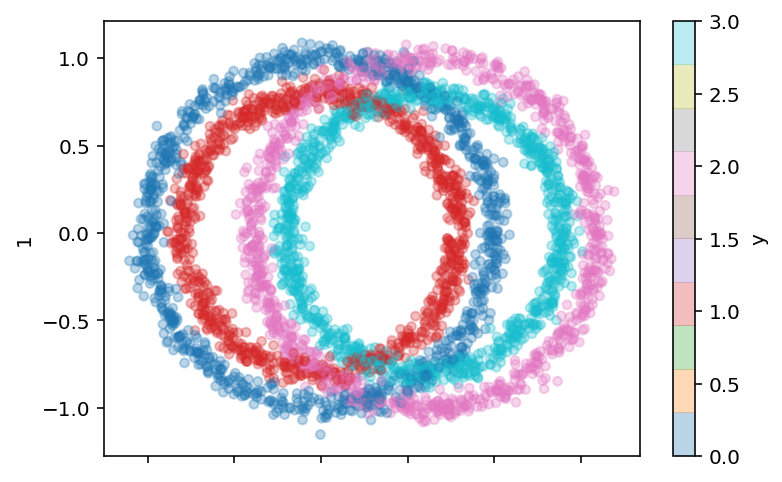

In [3]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd

X1, y1 = make_circles(n_samples=30_000, random_state=0, noise=0.04)
X2, y2 = make_circles(n_samples=30_000, random_state=1, noise=0.04)
X2[:, 0] += 0.6
X_info = np.concatenate((X1, X2))
y = np.concatenate((y1, y2 + 2))

df = pd.DataFrame(X_info)
df["y"] = y
df.sample(4_000).plot.scatter(x=0, y=1, c="y", cmap="tab10", alpha=0.3)


In [4]:
# add random features

from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_random_state

rng = check_random_state(42)
random_feats = rng.uniform(-1, 1, size=(X_info.shape[0], 4))
X_ = np.hstack((X_info, random_feats))

X = X_
# transform = PolynomialFeatures(degree=4)
# X = transform.fit_transform(X_)
X.shape

(60000, 6)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(10e3), random_state=42)


In [6]:
import numpy as np
assert np.unique(y).tolist() == [0, 1, 2, 3]

In [7]:
X_test.shape

(10000, 6)

Let's normalize the data as in https://github.com/zalandoresearch/fashion-mnist/blob/629abc0f9a73c2897383a9178e8e38f7141be30d/benchmark/runner.py#L40-L44

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from dask_ml.model_selection import HyperbandSearchCV

/Users/scott/anaconda3/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [10]:
import numpy as np
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

params = {
    "hidden_layer_sizes": [(24, ),
                           (12, ) * 2,
                           (6, ) * 4,
                           (4, ) * 6,
                           (12, 6, 3, 3)],  # 5
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [32, 64, 128, 256, 512],  # 5
    "learning_rate": ["constant", "invscaling"],  # 2
    "learning_rate_init": np.logspace(-4, -2, num=1000), # cnts
    "power_t": np.linspace(0.1, 0.9, num=1000), # cnts
    "momentum": np.linspace(0, 1, num=1000),  # cnts
    "nesterovs_momentum": [True],  # 1
    "n_iter_no_change": [np.inf],
    "solver": ["sgd"],
    "activation": ["relu"],
    "random_state": list(range(10_000)),
}

This is `1 * 6 * 3 = 18` discrete combinations. There are 2 or 3 continious variables to tune.

In [11]:
X_train.shape, y_train.shape

((50000, 6), (50000,))

Let's train for 30 epochs and sample 180 parameters (10 parameters for every discrete combo). According to the documentation, that means each chunk should be 1/6 of the dataset.

In [12]:
n_examples = 50 * len(X_train)
n_params = 300 - 1

max_iter = n_params
chunks = n_examples // n_params

max_iter, chunks

(299, 8361)

In [13]:
meta = HyperbandSearchCV(
    model, params, max_iter=max_iter, aggressiveness=4,
).metadata
_calls = meta["partial_fit_calls"]
print(_calls, meta["n_models"])
_n_models = _calls / max_iter
print(_n_models, max_iter)

5721 378
19.13377926421405 299


In [14]:
from dask_ml.model_selection import train_test_split
import dask.array as da
X_train = da.from_array(X_train, chunks=chunks)
y_train = da.from_array(y_train, chunks=chunks)

In [15]:
X_train.chunks

((8361, 8361, 8361, 8361, 8361, 8195), (6,))

In [16]:
classes = da.unique(y_train).compute()
print(classes)
y_train

[0 1 2 3]


dask.array<array, shape=(50000,), dtype=int64, chunksize=(8361,)>

In [17]:
import warnings
def fit_hyperband(model, params, max_iter=None, random_state=None):
    search = HyperbandSearchCV(
        model,
        params,
        max_iter=max_iter,
        random_state=random_state,
        patience=True,
        tol=np.nan,
        aggressiveness=4,
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        search.fit(X_train, y_train, classes=classes)
    # print(pd.DataFrame(search.history_)["partial_fit_calls"].max())
    assert pd.DataFrame(search.history_)["partial_fit_calls"].max() == max_iter
    return search


In [18]:
from dask_ml.model_selection import IncrementalSearchCV

def fit_passive(model, params, n_initial_params=None, max_iter=None, random_state=None):
    passive = IncrementalSearchCV(
        model,
        params,
        decay_rate=0,
        n_initial_parameters=n_init,
        max_iter=max_iter,
        random_state=random_state,
        scores_per_fit=10,
    )

    passive.fit(X_train, y_train, classes=classes)
    assert pd.DataFrame(passive.history_)["partial_fit_calls"].max() <= max_iter + 10
    return passive

In [19]:
searches = {"hyperband": [], "passive": []}

In [29]:
print({k: len(v) for k, v in searches.items()})

{'hyperband': 72, 'passive': 72}


In [30]:
from time import time
N = 200
N0 = 600
for k in range(N0, N0 + N):
    total_start = time()
    print(f"    starting hyperband {k}...", end="")
    start = time()
    search = fit_hyperband(model, params, max_iter=max_iter, random_state=k)
    print(f"   done in {time() - start:2f} seconds")
    searches["hyperband"].append(search)
    
    total_calls = search.metadata["partial_fit_calls"]
    n_init = total_calls / max_iter
    assert 5720 <= total_calls <= 5742
    assert 19.1 <= n_init <= 19.2
    # total_calls = n_init * one_model
    # set n_init = calls / one_model
    
    print(f"    starting  passive {k}...", end="")
    start = time()
    search = fit_passive(
        model,
        params,
        max_iter=max_iter,
        n_initial_params=n_init,
        random_state=k
    )
    print(f"   done in {time() - start:2f} seconds")
    searches["passive"].append(search)
    print(f"Total time for {k}: {time() - total_start}")

    starting hyperband 600...   done in 257.397747 seconds
    starting  passive 600...   done in 203.626497 seconds
Total time for 600: 461.02773880958557
    starting hyperband 601...   done in 244.288066 seconds
    starting  passive 601...   done in 183.694754 seconds
Total time for 601: 427.98850774765015
    starting hyperband 602...   done in 181.399844 seconds
    starting  passive 602...   done in 167.207720 seconds
Total time for 602: 348.6122999191284
    starting hyperband 603...   done in 250.365683 seconds
    starting  passive 603...   done in 186.910829 seconds
Total time for 603: 437.2793526649475
    starting hyperband 604...   done in 191.614292 seconds
    starting  passive 604...   done in 170.361694 seconds
Total time for 604: 361.980996131897
    starting hyperband 605...   done in 198.511843 seconds
    starting  passive 605...   done in 145.764677 seconds
Total time for 605: 344.28028178215027
    starting hyperband 606...   done in 178.062217 seconds
    start

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [31]:
{k: len(v) for k, v in searches.items()}

{'hyperband': 200, 'passive': 200}

In [32]:
import msgpack
# 2019-06-22 doesn't work for comparison because total work tool long
# both v3 and v2 have the new PR merged
# today = "2019-06-22-v2"  # v3 is v2, but run for longer
# today = "2019-06-22-v3"

# This uses aggressiveness=4
today = "2019-07-08"

def _get_history(search):
    params = {k: v for k, v in search.get_params().items()
              if "estimator" not in k and k != "parameters"
    }
    params["best_score_"] = search.best_score_
    out = [{**params, **h} for h in search.history_]
    return out

histories = {k: [_get_history(search) for search in alg_searches] for k, alg_searches in searches.items()}
with open(f"out/{today}-histories-2.msgpack", "wb") as f:
    msgpack.dump(histories, f)

best_scores = [
    {"score": search.best_score_, "alg": alg, **search.best_params_}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

best_params = [
    {"alg": alg, "best_score_": search.best_score_, **search.best_params_}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

# models = {k: [search.best_estimator_ for search in alg_searches] for k, alg_searches in searches.items()}
# with open(f"out/{today}-models.msgpack", "wb") as f:
#     msgpack.dump(models, f)

pd.DataFrame(best_scores).to_csv(f"out/{today}-best-scores.csv", index=False)
pd.DataFrame(best_params).to_csv(f"out/{today}-best-params.csv", index=False)

In [ ]:
import joblib

with open(f"out/{today}-histories-2.joblib", "wb") as f:
    joblib.dump(histories, f)

In [22]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 **kwargs}]
    return out

In [23]:
import pandas as pd

histories = [
    shape_history(search.history_, alg=alg_name, random_state=search.random_state)
    for alg_name, alg_searches in searches.items()
    for search in alg_searches
]

df = pd.DataFrame(sum(histories, []))
df.head(n=2)

,alg,best_score,cumulative_partial_fit_calls,elapsed_wall_time,random_state
0,hyperband,0.257948,1,0.000000,0
1,hyperband,0.265547,2,0.000003,0


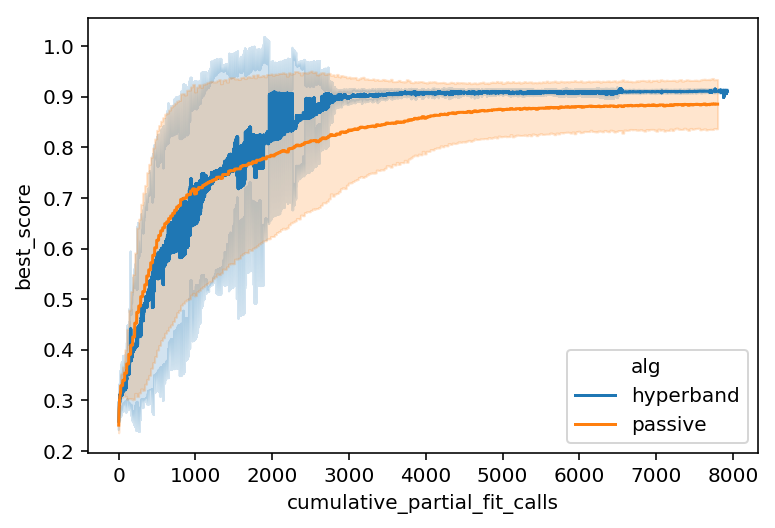

In [24]:
import seaborn as sns
ax = sns.lineplot(
    data=df,
    x="cumulative_partial_fit_calls",
    y="best_score",
    hue="alg",
    ci="sd",
)
# ax.set_ylim(0.5, None)

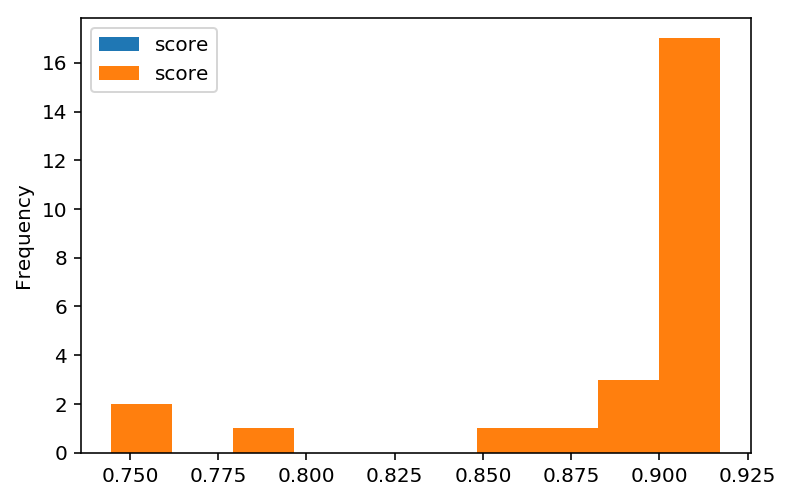

In [25]:
import matplotlib.pyplot as plt
best_scores = [
    {"score": search.best_score_, "alg": alg}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

show = pd.DataFrame(best_scores)
fig, ax = plt.subplots()
for alg in show.alg.unique():
    show[show.alg == alg].plot.hist(ax=ax, label=alg)

In [26]:
params = [
    {"alg": alg, **search.best_params_}
    for alg, alg_searches in searches.items()
    for search in alg_searches
]

params = pd.DataFrame(params)
params.drop(
    columns=[
        "n_iter_no_change",
        "activation",
        "nesterovs_momentum",
        "solver"
    ], inplace=True
)
params

,alg,alpha,batch_size,hidden_layer_sizes,learning_rate,learning_rate_init,momentum,power_t
0,hyperband,0.000660,64,"(12, 12)",constant,0.001222,0.875876,0.196096
1,hyperband,0.000007,256,"(24,)",constant,0.006135,0.990991,0.200100
2,hyperband,0.000001,64,"(12, 12)",constant,0.000285,0.980981,0.748649
3,hyperband,0.000380,64,"(12, 12)",constant,0.003627,0.828829,0.657357
4,hyperband,0.000003,64,"(12, 12)",constant,0.003030,0.953954,0.175275
5,hyperband,0.000487,512,"(12, 12)",constant,0.004917,0.982983,0.548448
6,hyperband,0.000769,64,"(12, 6, 3, 3)",constant,0.009908,0.891892,0.272172
7,hyperband,0.000013,32,"(12, 12)",constant,0.006948,0.220220,0.887187
8,hyperband,0.000020,128,"(12, 12)",constant,0.008471,0.542543,0.820721
9,hyperband,0.000004,64,"(12, 12)",constant,0.003217,0.913914,0.627728


In [27]:
best_scores

[{'score': 0.911617676464707, 'alg': 'hyperband'},
 {'score': 0.9072185562887423, 'alg': 'hyperband'},
 {'score': 0.9119176164767047, 'alg': 'hyperband'},
 {'score': 0.9095180963807239, 'alg': 'hyperband'},
 {'score': 0.9134173165366927, 'alg': 'hyperband'},
 {'score': 0.9093181363727254, 'alg': 'hyperband'},
 {'score': 0.9019196160767846, 'alg': 'hyperband'},
 {'score': 0.915116976604679, 'alg': 'hyperband'},
 {'score': 0.9062187562487503, 'alg': 'hyperband'},
 {'score': 0.9092181563687263, 'alg': 'hyperband'},
 {'score': 0.912617476504699, 'alg': 'hyperband'},
 {'score': 0.9130173965206959, 'alg': 'hyperband'},
 {'score': 0.9152169566086783, 'alg': 'hyperband'},
 {'score': 0.9108178364327134, 'alg': 'hyperband'},
 {'score': 0.9123175364927014, 'alg': 'hyperband'},
 {'score': 0.9085182963407319, 'alg': 'hyperband'},
 {'score': 0.9108178364327134, 'alg': 'hyperband'},
 {'score': 0.9090181963607279, 'alg': 'hyperband'},
 {'score': 0.9125174965006999, 'alg': 'hyperband'},
 {'score': 0.91